## Installation

In [1]:
!pip install pytorch-tabnet

## Import Libraries

In [2]:
# 環境によって処理を変えるためのもの
import sys
import os
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'kaggle_web_client' in sys.modules
LOCAL = not (IN_KAGGLE or IN_COLAB)
print(f'IN_COLAB:{IN_COLAB}, IN_KAGGLE:{IN_KAGGLE}, LOCAL:{LOCAL}')

IN_COLAB:False, IN_KAGGLE:True, LOCAL:False


In [3]:
# Hide Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Python Libraries
import os
import math
import random
import glob
import pickle
import gc
from pathlib import Path

# Third party
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn import preprocessing
from sklearn.model_selection import GroupKFold,StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error,roc_auc_score,accuracy_score

import category_encoders as ce
import optuna

import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier


def set_seed(seed: int=29):
    print(f'set_seed{seed}')
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
set_seed()

set_seed29


In [4]:
class CFG:
    competition = 'spaceship_titanic'
    seed = 29
    target_col = 'Transported'
    n_fold = 5
    trn_fold = [0,1,2,3,4]
    
    # Traininh
    # ==============================================================
    pretrain_param = {
        'model':{
            'n_d': 8,
            'n_a': 8,
            'n_steps': 3,
            'gamma': 1.3,
            'n_independent': 2,
            'n_shared': 2,
            'seed': seed,
            'lambda_sparse': 1e-3,
            'optimizer_fn':torch.optim.Adam,
            'optimizer_params':{'lr':2e-2},
            'mask_type': 'entmax',
            'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
            'scheduler_params': {
                'mode':'min',
                'patience':5,
                'min_lr': 1e-5,
                'factor': 0.9,
            },
            'verbose': 10
        },
        'fit':{
            'max_epochs': 200,
            'patience': 20,
            'batch_size': 256,
            'virtual_batch_size': 128,
            'num_workers': 1,
            'drop_last': True
        }
    }
    train_params = {
        'model':{
            'n_d': 8,
            'n_a': 8,
            'n_steps': 3,
            'gamma': 1.3,
            'n_independent': 2,
            'n_shared': 2,
            'seed': seed,
            'lambda_sparse': 1e-3,
            'optimizer_fn': torch.optim.Adam,
            'optimizer_params': {'lr': 2e-2, 'weight_decay': 1e-5},
            'mask_type': 'entmax',
            'scheduler_fn': torch.optim.lr_scheduler.OneCycleLR,
            'scheduler_params': {
                'max_lr': 0.05,
                'steps_per_epoch': 5,
                'epochs': 200,
                'is_batch_level': True,
            },
            'verbose': 10
        },
        'fit':{
            'eval_metric': ['accuracy',"auc"],
            'max_epochs': 200,
            'patience': 20,
            'batch_size': 256,
            'virtual_batch_size': 128,
            'num_workers': 0,
            'drop_last': False
        }
    }
    
    # Feature
    # ==============================================================
    fillna_value= {
        'Age': -1,
        'RoomService': -1,
        'FoodCourt': -1,
        'ShoppingMall': -1,
        'Spa': -1,
        'VRDeck': -1,
    }
    cate_cols = []
    cont_cols = []
    feature_cols = []

In [5]:
if IN_KAGGLE:
    INPUT_DIR = Path('../input/spaceship-titanic')
    OUTPUT_DIR = './'
elif IN_COLAB:
    INPUT_DIR = Path('/content/input/')
    OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/spaceship-titanic/{CFG.exp_name}/'
if LOCAL:
    INPUT_DIR = Path("F:/Kaggle/spaceship-titanic/data/input/")
    OUTPUT_DIR = f'F:/Kaggle/pspaceship-titanic/data/output/{CFG.exp_name}/'
    
df_train = pd.read_csv(INPUT_DIR / "train.csv")
df_test = pd.read_csv(INPUT_DIR / "test.csv")
df_sub = pd.read_csv(INPUT_DIR / "sample_submission.csv")
df_oof = df_train.copy()
display(df_train.head())
display(df_test.head())
display(df_sub.head())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [6]:
CFG.cate_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', ]
CFG.cont_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
CFG.feature_cols =  CFG.cont_cols  #+ CFG.cate_cols

## Feature Engneering

In [7]:
# fillna
df_train = df_train.fillna(CFG.fillna_value)
df_test = df_test.fillna(CFG.fillna_value)
print(df_train[CFG.cont_cols].isnull().sum())
df_train[CFG.cont_cols].describe()

Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.213735,219.988496,448.412976,169.548372,304.567813,298.240193
std,14.951705,660.526002,1595.796550,598.013969,1125.568266,1134.132115
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
# Caategory Encodeing
_OE_COLS = ['HomePlanet', 'CryoSleep', 'Destination','VIP']
OE_COLS = ['OE_' + col for col in _OE_COLS]
ce_oe = ce.OrdinalEncoder(cols=_OE_COLS,handle_missing='return_nan')
df_train[OE_COLS] = ce_oe.fit_transform(df_train[_OE_COLS])
df_test[OE_COLS] = ce_oe.transform(df_test[_OE_COLS])
# CFG.feature_cols += OE_COLS 
print(OE_COLS)

# One-Hot-Encoding
_OHE_COLS = ['HomePlanet', 'CryoSleep', 'Destination','VIP']
ce_ohe = ce.OneHotEncoder(cols=_OHE_COLS, handle_unknown='impute')
_df_ohe = ce_ohe.fit_transform(df_train[_OHE_COLS])
OHE_COLS = _df_ohe.columns.to_list()
df_train[OHE_COLS] = _df_ohe[OHE_COLS]
df_test[OHE_COLS] = ce_ohe.transform(df_test[_OHE_COLS])
CFG.feature_cols += OHE_COLS 
print(OHE_COLS)

['OE_HomePlanet', 'OE_CryoSleep', 'OE_Destination', 'OE_VIP']
['HomePlanet_1', 'HomePlanet_2', 'HomePlanet_3', 'HomePlanet_4', 'CryoSleep_1', 'CryoSleep_2', 'CryoSleep_3', 'Destination_1', 'Destination_2', 'Destination_3', 'Destination_4', 'VIP_1', 'VIP_2', 'VIP_3']


## CV Split

In [9]:
print(df_train.Transported.value_counts())
df_train["fold"] = -1
"""
StratifiedKFold
"""
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(df_train, df_train[CFG.target_col])):
    df_train.loc[val_index, 'fold'] = int(n)
    
"""
"""
df_train['fold'] = df_train['fold'].astype(int)
df_oof['fold'] = df_train['fold']
print(df_train.groupby(['fold', CFG.target_col]).size())

True     4378
False    4315
Name: Transported, dtype: int64
fold  Transported
0     False          863
      True           876
1     False          863
      True           876
2     False          863
      True           876
3     False          863
      True           875
4     False          863
      True           875
dtype: int64


## Function

In [10]:
"""==============================
Pretrain
=============================="""

unsupervised_model = TabNetPretrainer(**CFG.pretrain_param["model"])

unsupervised_model.fit(
    X_train=df_train.loc[df_train['fold'] != 0, CFG.feature_cols].to_numpy(),
    eval_set=[df_train.loc[df_train['fold'] == 0, CFG.feature_cols].to_numpy()],
    **CFG.pretrain_param["fit"]
)

Device used : cpu
epoch 0  | loss: 8.76107 | val_0_unsup_loss: 2.43717 |  0:00:01s
epoch 10 | loss: 0.90019 | val_0_unsup_loss: 0.90567 |  0:00:13s
epoch 20 | loss: 0.82353 | val_0_unsup_loss: 0.83969 |  0:00:24s
epoch 30 | loss: 0.80908 | val_0_unsup_loss: 0.83124 |  0:00:36s
epoch 40 | loss: 0.78099 | val_0_unsup_loss: 0.79091 |  0:00:47s
epoch 50 | loss: 0.78203 | val_0_unsup_loss: 0.78524 |  0:00:59s
epoch 60 | loss: 1442.95286| val_0_unsup_loss: 0.78653 |  0:01:10s
epoch 70 | loss: 0.77437 | val_0_unsup_loss: 0.77647 |  0:01:22s
epoch 80 | loss: 0.7581  | val_0_unsup_loss: 0.71905 |  0:01:34s
epoch 90 | loss: 0.76374 | val_0_unsup_loss: 0.72381 |  0:01:45s
epoch 100| loss: 0.76346 | val_0_unsup_loss: 0.72396 |  0:01:57s
epoch 110| loss: 0.74189 | val_0_unsup_loss: 0.71853 |  0:02:08s
epoch 120| loss: 0.75932 | val_0_unsup_loss: 0.73961 |  0:02:20s

Early stopping occurred at epoch 127 with best_epoch = 107 and best_val_0_unsup_loss = 0.71339
Best weights from best epoch are automa

In [11]:
def fit_tabnet(cfg, X_train, y_train, X_valid, y_valid, unsupervised_model=None):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    
    clf = TabNetClassifier(**cfg.train_params["model"])
    clf.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_valid, y_valid)],
        eval_name = ["valid"],
        **cfg.train_params["fit"],
        from_unsupervised=unsupervised_model
            )
    oof_pred = clf.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, oof_pred)
    return oof_pred, clf, score

## Training

In [12]:
# set params
CFG.train_params["model"]["scheduler_params"]["steps_per_epoch"] = int(math.ceil((df_train['fold'] != 0).sum()/CFG.train_params["fit"]["batch_size"]))


models = []
for fold in tqdm(range(CFG.n_fold)):
    if not fold in CFG.trn_fold:
        continue
    print(f"{'='*38} Fold: {fold} {'='*38}")

    oof_pred, model, score = fit_tabnet(CFG,
                                       df_train.loc[df_train['fold'] != fold, CFG.feature_cols].to_numpy(),
                                       df_train.loc[df_train['fold'] != fold, CFG.target_col].to_numpy(),
                                       df_train.loc[df_train['fold'] == fold, CFG.feature_cols].to_numpy(),
                                       df_train.loc[df_train['fold'] == fold, CFG.target_col].to_numpy(),
                                       unsupervised_model,)
    # oof
    df_oof.loc[df_train['fold'] == fold,['pred']] = oof_pred
    models.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

====================================== Fold: 0 ======================================
Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 1.08258 | valid_accuracy: 0.50374 | valid_auc: 0.63819 |  0:00:00s
epoch 10 | loss: 0.44797 | valid_accuracy: 0.79241 | valid_auc: 0.87871 |  0:00:09s
epoch 20 | loss: 0.44808 | valid_accuracy: 0.79011 | valid_auc: 0.88052 |  0:00:17s
epoch 30 | loss: 0.44336 | valid_accuracy: 0.79586 | valid_auc: 0.88327 |  0:00:26s
epoch 40 | loss: 0.43859 | valid_accuracy: 0.74411 | valid_auc: 0.87736 |  0:00:35s
epoch 50 | loss: 0.43997 | valid_accuracy: 0.76481 | valid_auc: 0.88599 |  0:00:44s
epoch 60 | loss: 0.43339 | valid_accuracy: 0.78321 | valid_auc: 0.88247 |  0:00:52s

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_auc = 0.88952
Best weights from best epoch are automatically used!
====================================== Fold: 1 ======================================
Device used : cpu
Loading weights fr

<AxesSubplot:>

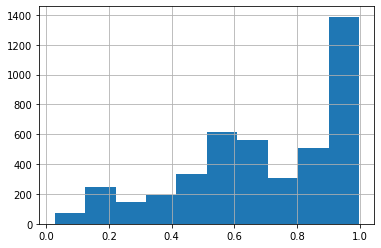

In [13]:
df_oof[df_oof['Transported'] == True].pred.hist()

In [14]:
print(f'roc_auc:{roc_auc_score(df_oof.Transported, df_oof.pred)}')
df_oof['pred_bool'] = df_oof.pred > 0.5
print(f'accuracy:{accuracy_score(df_oof.Transported, df_oof.pred_bool)}')

roc_auc:0.8773210569861845
accuracy:0.7919015299666399


In [15]:
y_preds =[]
for model in models:
    y_pred = model.predict_proba(df_test[CFG.feature_cols].to_numpy())[:,1]
    y_preds.append(y_pred)
pred = np.mean(y_preds,axis=0)

In [16]:
df_sub['Transported'] = pred > 0.5
df_sub.to_csv('submission.csv', index=False)

In [17]:
model.feature_importances_

array([0.06216927, 0.09910269, 0.05559745, 0.03425378, 0.03554666,
       0.03820172, 0.18200058, 0.0859693 , 0.01308144, 0.00843369,
       0.04491653, 0.00871459, 0.00090478, 0.08188619, 0.02350554,
       0.090977  , 0.0246456 , 0.09727473, 0.0044615 , 0.00835696])

## reference

- https://www.kaggle.com/code/sinchir0/selfsupervisedtabnet-titanic-comparing-lgbm-nn

## To-Do

- wandb対応
- 正規化が必要か調査
- GPUで動かせるようにする
- カテゴリ変数の扱い

cat_idxs=cat_idxs, # comment out when Unsupervised
                         cat_dims=cat_dims, # comment out when Unsupervised